# **PushBlock PPO**

### **Imports**

In [1]:
from config import *
from rlkit.util import Checkpointer, Logger, SimpleMetricModule

import pandas as pd
import matplotlib.pyplot as plt
from train_util import *
import matplotlib.pyplot as plt
from env import create_env

## **Inspect Environment**

In [2]:
try: env.close()
except: pass

env = create_env(graphics=False, time_scale=10)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/transforms/transforms.py:587: FutureWarning: The key 'discrete_action' is unaccounted for by the transform (expected keys ['StackingSensor_size3_OffsetRayPerceptionSensor', 'StackingSensor_size3_RayPerceptionSensor', 'done', 'terminated', 'truncated', 'group_reward', 'reward']). Every new entry in the tensordict resulting from a call to a transform must be registered in the specs for torchrl rollouts to be consistently built. Make sure transform_output_spec/transform_observation_spec/... is coded correctly. This warning will trigger a KeyError in v0.9, make sure to adapt your code accordingly.
  warnings.warn(


In [3]:
data = env.rollout(100, break_when_any_done=False)

ERROR: Shader UI/Default shader is not supported on this GPU (none of subshaders/fallbacks are suitable)


In [4]:
data

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([32, 100, 7]), device=cpu, dtype=torch.int32, is_shared=False),
        done: Tensor(shape=torch.Size([32, 100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([32, 100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([32, 100, 210]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([32, 100, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([32, 100, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([32, 100, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([32, 100]),
            device=cpu,
            is_shared=False),
        observation: Tensor(shape=torch.Size([32,

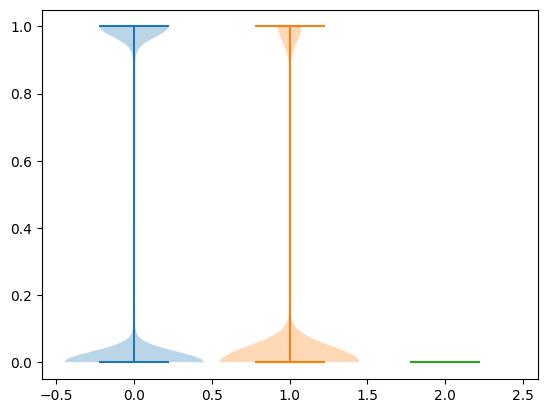

In [5]:
obs_df = pd.DataFrame(data["observation"].reshape(-1))
act_df = pd.DataFrame(data["action"].reshape(-1))
rew_df = pd.DataFrame(data["next", "reward"].reshape(-1))

for i, df in enumerate([obs_df, act_df, rew_df]):
    plt.violinplot(df, positions=[i], widths=0.9)

## **Results**

In [8]:
def plot(name):
    # Get dataframe
    logger = Logger(keys = LOG_KEYS, log_path=LOG_PATH, name=name)
    logger.revert()
    df = logger.dataframe()
    df = df.set_index(LOG_INDEX)

    # Plot it
    rows = (len(df.columns) + 3) // 4
    df.plot(subplots=True, layout=(rows,4), figsize=(15, int(rows* 7/3)))
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, f"{name}.png"))

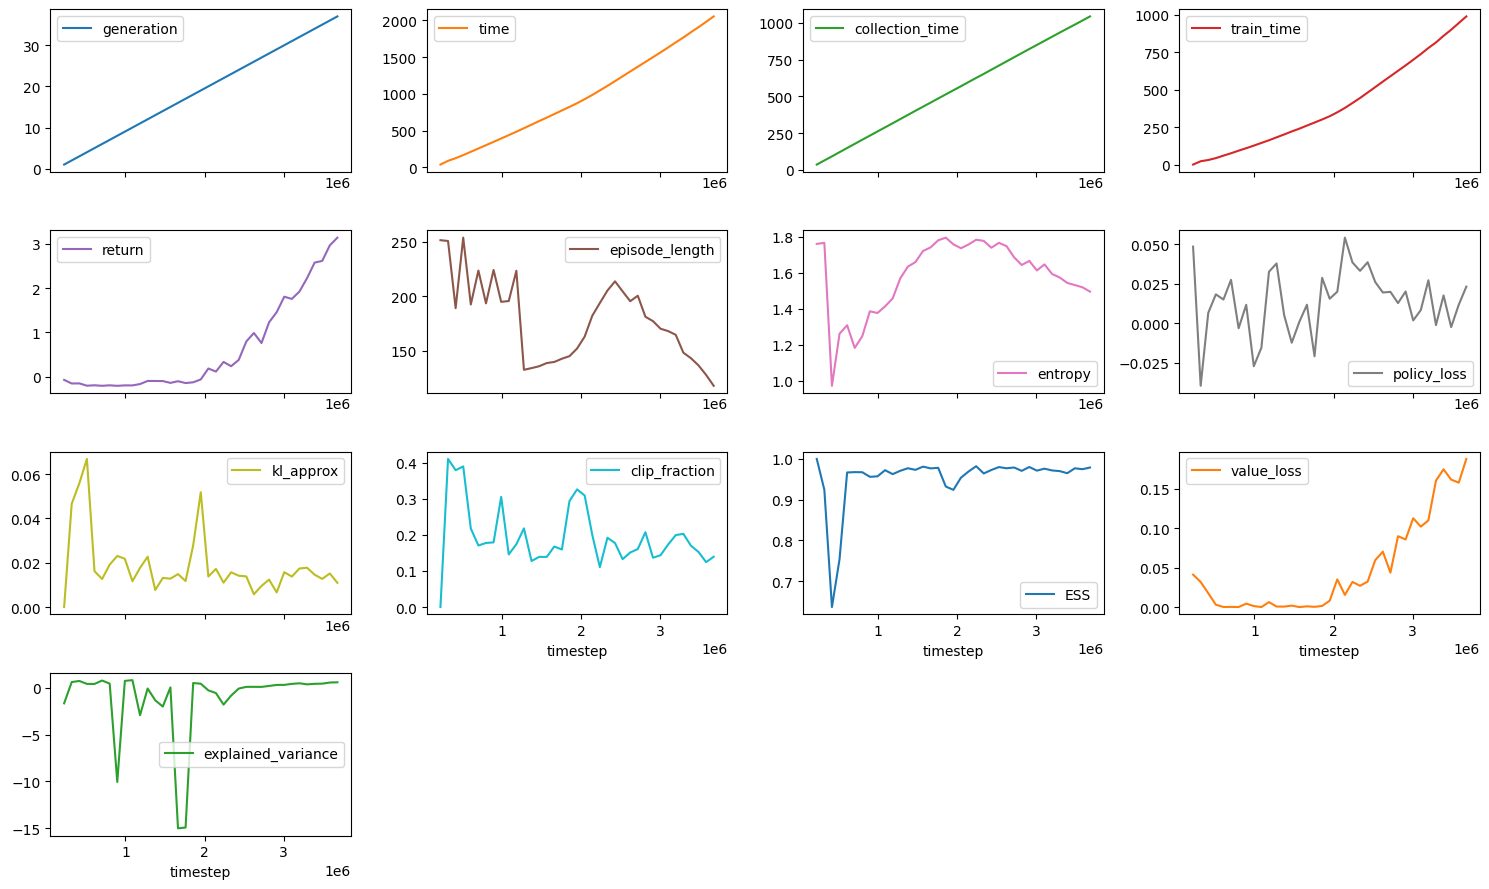

In [9]:
plot(NAME)

In [2]:
def load_policy_from_model(policy, model_path, name):
    model_params = torch.load(os.path.join(model_path, f"{name}.pt"), map_location="cpu", weights_only=True)
    policy.load_state_dict(model_params["policy_state_dict"])

def load_policy_from_checkpoint(policy, ckpt_path, name, ckpt_type='latest'):
    checkpointer = Checkpointer(ckpt_path=ckpt_path, name=name)
    checkpoint = checkpointer.load_progress()
    checkpoint = torch.load(os.path.join(ckpt_path, f"{name}_{ckpt_type}.ckpt"), map_location="cpu", weights_only=True)
    policy.load_state_dict(checkpoint["policy_state_dict"])

policy = create_policy(MODEL_CONFIG).to(device)
# load_policy_from_model(policy, MODEL_PATH, NAME)
load_policy_from_checkpoint(policy, CKPT_PATH, NAME, ckpt_type='latest')

In [3]:
try: env.close()
except: pass

env = create_env(graphics=True, time_scale=5)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/transforms/transforms.py:587: FutureWarning: The key 'discrete_action' is unaccounted for by the transform (expected keys ['StackingSensor_size3_OffsetRayPerceptionSensor', 'StackingSensor_size3_RayPerceptionSensor', 'done', 'terminated', 'truncated', 'group_reward', 'reward']). Every new entry in the tensordict resulting from a call to a transform must be registered in the specs for torchrl rollouts to be consistently built. Make sure transform_output_spec/transform_observation_spec/... is coded correctly. This warning will trigger a KeyError in v0.9, make sure to adapt your code accordingly.
  warnings.warn(


In [5]:
data = None
with torch.no_grad():
    data = env.rollout(1000, policy=policy, break_when_any_done=False)

KeyboardInterrupt: 

: 

In [7]:
data

TensorDict(
    fields={
        action: Tensor(shape=torch.Size([24, 1000, 54]), device=cpu, dtype=torch.int64, is_shared=False),
        done: Tensor(shape=torch.Size([24, 1000, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        log_prob: Tensor(shape=torch.Size([24, 1000]), device=cpu, dtype=torch.float32, is_shared=False),
        logits: Tensor(shape=torch.Size([24, 1000, 54]), device=cpu, dtype=torch.float32, is_shared=False),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([24, 1000, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([24, 1000, 444]), device=cpu, dtype=torch.float32, is_shared=False),
                reward: Tensor(shape=torch.Size([24, 1000, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([24, 1000, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=tor

In [55]:
try: env.close()
except: pass

In [56]:
SimpleMetricModule(mode="approx")(data)

{'return': 0.9211098551750183,
 'episode_length': 29.447853088378906,
 'entropy': 0.37978869676589966}